<a href="https://colab.research.google.com/github/Letch49/ML_VVSU_2023/blob/main/cluster_profiling_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint

In [2]:
# Загрузка данных Wine
wine_data = load_wine()

df_original = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
df_original

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


Набор данных состоит из следующих переменных:

1. **Alcohol**: Крепость напитка.
2. **Malic Acid**: Содержание яблочной кислоты.
3. **Ash**: Содержание золы.
4. **Alcalinity of Ash**: Щелочность золы.
5. **Magnesium**: Содержание магния.
6. **Total Phenols**: Общее количество фенолов.
7. **Flavanoids**: Содержание флавоноидов.
8. **Nonflavanoid Phenols**: Нефлавоноидные фенолы.
9. **Proanthocyanins**: Проантоцианидины.
10. **Color Intensity**: Интенсивность цвета.
11. **Hue**: Оттенок.
12. **OD280/OD315 of Diluted Wines**: Оптическая плотность.
13. **Proline**: Содержание пролина.

В большинстве случаев - наши переменные содержать химические вещества + какие-то измерения по цвету. Интуитивно, думаю что не стоит анализировать признаки связанные с цветом и оптической плотностью, хочу построить модель только по химическим веществам

In [3]:
df_original.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [4]:
df_original = df_original.drop(labels=['color_intensity', 'hue', 'od280/od315_of_diluted_wines'], axis=1)
df = df_original.copy() # для упрощения работы, делаем df_original и df, df - будет переменной для использования, а df_original - для профилирования
df.info() # все переменные числовые

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alcohol               178 non-null    float64
 1   malic_acid            178 non-null    float64
 2   ash                   178 non-null    float64
 3   alcalinity_of_ash     178 non-null    float64
 4   magnesium             178 non-null    float64
 5   total_phenols         178 non-null    float64
 6   flavanoids            178 non-null    float64
 7   nonflavanoid_phenols  178 non-null    float64
 8   proanthocyanins       178 non-null    float64
 9   proline               178 non-null    float64
dtypes: float64(10)
memory usage: 14.0 KB


In [5]:
COLUMNS_TRANSLATION = {
    "alcohol": "Алкоголь",
    "malic_acid": "Яблочная кислота",
    "ash": "Зола",
    "alcalinity_of_ash": "Щелочность золы",
    "magnesium": "Магний",
    "total_phenols": "Общие фенолы",
    "flavanoids": "Флавоноиды",
    "nonflavanoid_phenols": "Нефлавоноидные фенолы",
    "proanthocyanins": "Проантоцианидины",
    "color_intensity": "Интенсивность цвета",
    "hue": "Оттенок",
    "od280/od315_of_diluted_wines": "OD280/OD315 разбавленных вин",
    "proline": "Пролин"
}

In [6]:
from sklearn.preprocessing import StandardScaler


def get_scaled_df(df):
    # Создаем экземпляр StandardScaler
    scaler = StandardScaler()

    scaled_data = scaler.fit_transform(df)

    # Преобразуем обратно в DataFrame для удобства работы
    df = pd.DataFrame(scaled_data, columns=df.columns)
    return df

get_scaled_df(df)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.037874
...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,0.296498


Немного про **.fit()** и **.transform()**

**.fit()** - метод для обозначения процесса обучения модели (например для StandatdScaler - это вычислить среднее и стандартное отклонение)

**.transform()** - сделать преобразования данных. То есть, например в StandardScaler - преобразовать данные (как x - mean ) / std (выше преобразованная матрица)

**.fit_transform()** - объединение сразу двух методов .fit() и .transform(). на вход подаем переменные для преобразования, вызывается .fit() и .transform() и на выходе выдются преобразованные данные



с .fit() и .predict() точно такая же история

In [7]:

# Кластеризация KMeans для данных Wine
AUTO_N_INIT = 'auto'
range_n_clusters = range(2,10)
X = get_scaled_df(df).to_numpy()

silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=AUTO_N_INIT)
    cluster_labels = kmeans.fit_predict(X)

    # Вычисление силуэтной оценки
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Определение оптимального числа кластеров для данных Wine
optimal_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
print('Оптимальное число кластеров:', optimal_n_clusters)
silhouette_scores


Оптимальное число кластеров: 2


[(2, 0.28475112438011463),
 (3, 0.2532162007902241),
 (4, 0.1922888552357632),
 (5, 0.15681023964669752),
 (6, 0.14399034930402257),
 (7, 0.1400836310263267),
 (8, 0.17479617646637216),
 (9, 0.18655117931609091)]

По метрике силуэта (**silhouette_score**) выбираем оптимальное число кластеров.

В результате получаем, что оптимальное число кластеров = 2, тк метрика = 0.42.

Метрика силуэта имеет диапазон от -1 до +1, где:

Значение близкое к +1 означает, что объект находится близко к другим объектам в своем кластере и далеко от объектов других кластеров, что указывает на хорошую кластеризацию.

Значение близкое к 0 означает, что объект находится на периферии своего кластера, с некоторым перекрытием с ближайшим кластером, что может указывать на перекрытие или нечеткие границы между кластерами.

Значение близкое к -1 означает, что объект, возможно, был неправильно сгруппирован, поскольку он ближе к объектам других кластеров, чем к объектам в своем собственном кластере.


In [9]:

n_clusters = optimal_n_clusters

model = KMeans(n_clusters=n_clusters, random_state=42, n_init=AUTO_N_INIT)
model.fit(X)

KMeans(n_clusters=2, n_init='auto', random_state=42)

In [10]:

model.labels_ # свойство .labels_ возвращает номера кластеров для каждой строки. В данном случае, существуют 2 кластероа [0, 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [11]:

df = df_original.copy()
df['labels'] = model.labels_
df['labels'] = df.labels.astype('category')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   alcohol               178 non-null    float64 
 1   malic_acid            178 non-null    float64 
 2   ash                   178 non-null    float64 
 3   alcalinity_of_ash     178 non-null    float64 
 4   magnesium             178 non-null    float64 
 5   total_phenols         178 non-null    float64 
 6   flavanoids            178 non-null    float64 
 7   nonflavanoid_phenols  178 non-null    float64 
 8   proanthocyanins       178 non-null    float64 
 9   proline               178 non-null    float64 
 10  labels                178 non-null    category
dtypes: category(1), float64(10)
memory usage: 14.3 KB


In [13]:
pd.set_option('display.max_rows', 80) # для удосбтва анализа делаем
df.groupby('labels', observed=True).agg(['count','mean', 'std']).T

labels                                1           0
alcohol              count    76.000000  102.000000
                     mean     13.446711   12.668235
                     std       0.779934    0.664809
malic_acid           count    76.000000  102.000000
                     mean      1.950132    2.624118
                     std       0.775606    1.242794
ash                  count    76.000000  102.000000
                     mean      2.427632    2.320980
                     std       0.279103    0.262963
alcalinity_of_ash    count    76.000000  102.000000
                     mean     17.794737   20.761765
                     std       3.320598    2.749727
magnesium            count    76.000000  102.000000
                     mean    106.342105   94.823529
                     std      15.020477   11.521321
total_phenols        count    76.000000  102.000000
                     mean      2.837895    1.890686
                     std       0.381315    0.437706
flavanoids           count    76.000000  102.000000
                     mean      2.921711    1.364314
                     std       0.554009    0.688991
nonflavanoid_phenols count    76.000000  102.000000
                     mean      0.288684    0.416373
                     std       0.081574    0.123174
proanthocyanins      count    76.000000  102.000000
                     mean      2.012763    1.276569
                     std       0.489861    0.402754
proline              count    76.000000  102.000000
                     mean   1005.868421  553.931373
                     std     296.832134  142.441043

Анализируя представленные данные по двум кластерам вина, можно сделать следующие выводы:

1. **Алкоголь (Alcohol)**: Кластер 1 имеет более высокую среднюю крепость (среднее значение алкоголя) по сравнению с Кластером 0. Это может указывать на то, что вина в Кластере 1 более крепкие. (в среднем на 0.9%)
2. **Яблочная кислота (Malic Acid)**: Вина в Кластере 0 имеют более высокое среднее содержание яблочной кислоты по сравнению с Кластером 1. Это может свидетельствовать о более высокой кислотности вин в Кластере 0. (в 2 раза)
3. **Зола (Ash)**: Среднее значение золы немного выше в Кластере 1. 🤷‍♂, видимо это что-то да значит
4. **Щелочность золы (Alcalinity of Ash)**: Вина в Кластере 0 имеют более высокую среднюю щелочность золы. 🤷‍♂
5. **Магний (Magnesium)**: Вина в Кластере 1 содержат больше магния. 🤷‍♂
6. **Общие фенолы (Total Phenols)**: Вина в Кластере 1 содержат больше общих фенолов. 🤷‍♂ короче я не спец по винам, если спросить у сомелье, вероятно он даст ответ с точки зрения вина
7. **Флавоноиды (Flavanoids)**: Значительно выше в Кластере 1. 🤷‍♂
8. **Нефлавоноидные фенолы (Nonflavanoid Phenols)**: Среднее ниже в Кластере 1. 🤷‍♂
9. **Проантоцианидины (Proanthocyanins)**: Выше в Кластере 1. 🤷‍♂
10. **Пролин (Proline)**: Вина в Кластере 1 имеют значительно более высокий средний уровень пролина. 🤷‍♂

**Кластер 1**:
- Более высокое среднее значение алкоголя и меньшее стандартное отклонение, указывающее на однородность в крепости вин.
- Ниже средние значения яблочной кислоты, магния, флавоноидов и пролина с меньшим разбросом данных, что свидетельствует о более стандартизированных характеристиках вин.

**Кластер 0**:
- Меньшая крепость алкоголя с большим разбросом значений, что указывает на разнообразие вин.
- Более высокое среднее содержание яблочной кислоты и больший разброс других химических показателей, отражающий большее разнообразие вин в этом кластере.

**Общий вывод**: Кластер 1 представляет собой более однородную группу вин, в то время как Кластер 0 характеризуется большим разнообразием. Это может отражать различия в процессе производства или сортах винограда или хранения для каждого кластера. Нужно учитывать контекст датасета

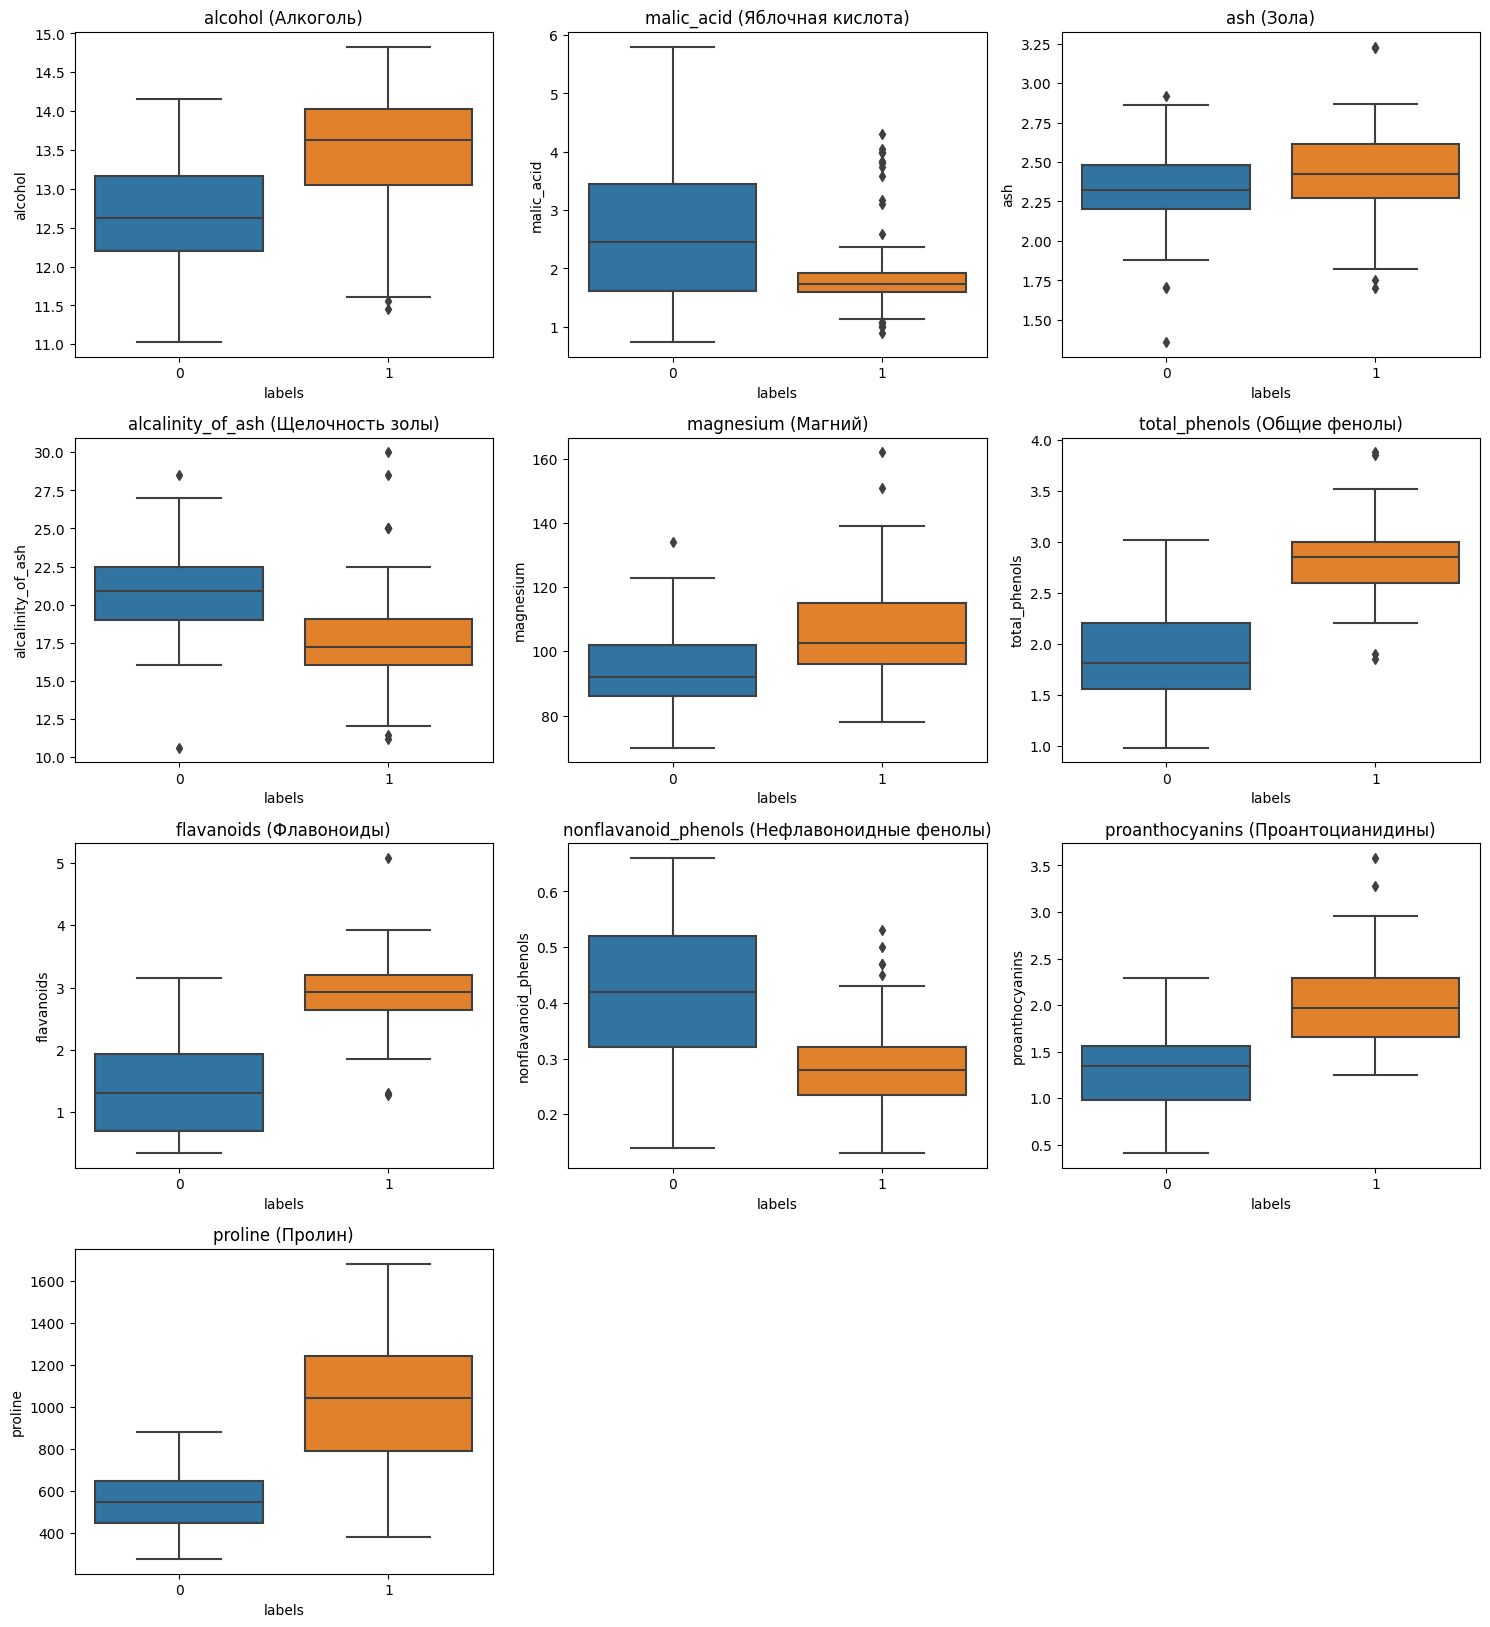

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))

# Создание boxplot для каждой колонки с разделением по меткам кластеров
for i, column in enumerate(df.columns[:-1], 1):  # Исключаем последний столбец 'labels'
    plt.subplot(5, 3, i)  # Установка 5 строк и 3 столбцов для графиков
    sns.boxplot(data=df, x='labels', y=column)
    plt.title(f'{column} ({COLUMNS_TRANSLATION.get(column)})')

plt.tight_layout()
plt.show()

- **Алкоголь**: Медианное значение и IQR в кластере 1 указывают на более высокое содержание алкоголя по сравнению с кластером 0. Большинство значений в кластере 1 находится в более высоком диапазоне, что может быть важным признаком для различения кластеров.
- **Яблочная кислота**: Данные по яблочной кислоте в кластере 1 полностью пересекаются с кластером 0, что свидетельствует об отсутствии межгрупповых различий. С точки зрения машинного обучения, этот признак может не способствовать различению между кластерами.
- **Зола**: Аналогично яблочной кислоте, распределения золы в обоих кластерах сильно перекрываются, что также указывает на низкую дискриминационную способность этого признака.
- **Щелочность золы**: Здесь наблюдаются более заметные различия между кластерами, особенно в верхней части распределения (75% квартиль). Это может указывать на наличие более выраженных межгрупповых различий, что делает этот признак потенциально полезным для классификации.
Продолжаем анализ boxplot'ов по оставшимся переменным:
- **Магний (Magnesium)**: В кластере 1 значения магния в среднем выше, чем в кластере 0, что может указывать на различия в составе. Однако значительное перекрытие между кластерами снижает его дискриминационную способность.
- **Общие фенолы (Total Phenols)**: Наблюдается четкое различие между кластерами, особенно в верхнем квартиле. Это указывает на потенциальную полезность этого признака для разделения кластеров.
- **Флавоноиды (Flavanoids)**: Аналогично общим фенолам, флавоноиды демонстрируют заметные различия между кластерами, особенно в медианных значениях и IQR. Это делает их важным признаком для классификации.
- **Нефлавоноидные фенолы (Nonflavanoid Phenols)**: Различия в распределении между кластерами менее выражены, что может снижать их важность для разделения групп.
- **Проантоцианидины (Proanthocyanins)**: Есть некоторое различие в распределении между кластерами, особенно в верхних квартилях, что может быть полезным для анализа.
- **Пролин (Proline)**: Значительное различие в распределении между кластерами, особенно в верхних квартилях, делает пролин ключевым признаком для классификации.

**Общий вывод**: Некоторые химические характеристики, такие как алкоголь, общие фенолы, флавоноиды, и пролин, показывают заметные различия в распределении между кластерами, что делает их ценными для задач классификации и кластеризации. Другие характеристики, такие как магний и нефлавоноидные фенолы, имеют меньшее различие в распределении, что может снижать их важность для разделения групп.


Подобный анализ необходим для отбора потенцально важных признаков, для более качественного разделения данных.
Например, если мы сделаем кластеризацию по признакам, которые имеют наиболее раздленеие (по среднему, медиане), то вероятно мы улучшим качество метрики.

В прошлом примере, значение получилось кластеров: 2, инлдекс-силуэта: 0.28

In [15]:
# Выбор только интересующих признаков
features = df[['flavanoids','proline']]
X = get_scaled_df(features).to_numpy()

silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=AUTO_N_INIT)
    cluster_labels = kmeans.fit_predict(X)

    # Вычисление силуэтной оценки
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Нахождение оптимального количества кластеров
optimal_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]

print('Оптимальное число кластеров:', optimal_n_clusters)
silhouette_scores

Оптимальное число кластеров: 2


[(2, 0.5472235171318104),
 (3, 0.4890580085815834),
 (4, 0.44486931780155986),
 (5, 0.42904414782291084),
 (6, 0.37740431046424705),
 (7, 0.3863536695039529),
 (8, 0.34308883628722625),
 (9, 0.36946981044291816)]

Как видим, у нас получилось увеличить индекс силуэта в 3 раза относительно n_cluster=2.
Также относительно другого количества кластеров - скорость ухудшения индекса меньшая + всегда > 0

Что может свидетельствовать о:
1. результат по двум точкам ['flavanoids','proline'] сопоставим с результатом по всему набору данных, значит нам не обязательно использовать все характеристики по кластерам
2. наша условия функцич потерь "индекс силуэта" с увеличением кластеров уменьшается с более меьшей скоростью.

Как можно дальше использовать полученные результаты?

1. использовать лейлблы кластеров для задачи регресси (узнать влияние кластеров на стоимость продукта)
2. использовать для задачи классификации (например "сорт винограда", "оценка типа вина")
3. рекомендации по вину относительно предпочтений по содержанию хим. состава
4. возможно как-то дальше исспользовать. Важен контекст исследования, к сожалению сейчас у нас его нет